In [185]:
##教训：MNIST本来是归一化的，调用时使用归一化参数反而不归一了
##如果拿不加限制的去拟合0 1之间的数，或者拿0 1去拟合超出区间的数，训练时间会暴涨，尤其后者
#####原先不用sigmoid去训练用了归一化参数的训练集属于是瞎猫碰到死耗子
##二值图像可以用BCELoss也可以用MSE，看假设的分布是什么了，如果是高斯就MSE，伯努利就BCE

In [112]:
import numpy as np
import torch
from torch.utils.data import dataset as Dataset
from torch.utils.data import dataloader as DataLoader
from torch import nn
import torchvision
import pandas as pd
import scipy.stats as st
import seaborn as sns
from matplotlib import pyplot as plt

import time

In [165]:
class VAE_dense(nn.Module):
    def __init__(self, input_size:int, output_size:int):
        super().__init__()
        self.input_size = input_size * input_size
        self.output_size = output_size * output_size
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )
        self.mu_z = nn.Linear(32, 16)
        self.log_var_z = nn.Linear(32, 16)

    def forward(self, X):
        X = self.encoder(X)
        mu_z = self.mu_z(X)
        log_var_z = self.log_var_z(X)
        eps = torch.randn_like(mu_z)
        X = mu_z + torch.exp(0.5 * log_var_z) * eps
        X = self.decoder(X)
        return (X, mu_z, log_var_z)

In [177]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.4914,), (0.2023,))
])
dataset = torchvision.datasets.MNIST('D:/Code_software/Jupyter_Notebook/data/mnist/test', transform=transform)

In [178]:
pct = 0.75
train_volume = round(len(dataset) * 0.75)
valid_volume = len(dataset) - train_volume
train_set, valid_set = Dataset.random_split(dataset, [train_volume, valid_volume])

In [179]:
batch_size = 256
train_iter = DataLoader.DataLoader(train_set, batch_size, shuffle=True)
valid_iter = DataLoader.DataLoader(valid_set, batch_size, shuffle=True)

In [180]:
tspic, _ = next(iter(train_iter))
tspic

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [181]:
class Accumulator():
    def __init__(self, n):
        self.matrix = [0.0] * n

    def add(self, *args):
        self.matrix = [a + float(b) for a, b in zip(self.matrix, args)]

    def reset(self):
        self.matrix = [0.0] * len(self.matrix)

    def __getitem__(self, index):
        return self.matrix[index]

def loss_func(mse, mu, log_var):
    kl_divergence = - 0.5 * torch.sum(log_var - log_var.exp() - torch.pow(mu, 2) + 1) #tensor可以直接exp()等同于 exp(tensor)
    loss = mse + kl_divergence
    return loss, mse, kl_divergence

def accuracy(X, X_hat):
    return (X_hat.type(X.dtype)==X).type(X_hat.dtype).sum()

def eval_accuracy(net, data_iter, device):
    if isinstance(net, nn.Module):
        net.eval()
    net = net.to(device)
    count = Accumulator(2)
    for X, _ in data_iter:
        X = X.to(device)
        count.add(accuracy(X, net(X)[0]), X.numel())
    return count[0] / count[1]

In [182]:
vae = VAE_dense(28, 28)
epochs, lr, weight_decay = 100, 0.01, 0
loss = nn.MSELoss(reduction='sum')
device = torch.device("cuda")

In [183]:
def train(net, train_iter, loss, epochs, lr, weight_decay, device):
    if isinstance(net, nn.Module):
        net.train()
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    train_ls = []
    train_acc = []
    matrix = Accumulator(4)
    time_taken = []
    for i in range(epochs):
        time_start = time.time()
        for X, _ in train_iter:
            X = X.to(device)
            optimizer.zero_grad()
            predict, mu, log_var = net(X)
            all_loss, mse_loss, kl_loss = loss_func(loss(predict, X), mu, log_var)
            l = all_loss
            l.backward()
            optimizer.step()
            matrix.add(l, X.shape[0], mse_loss, kl_loss)
        time_taken.append(time.time() - time_start)
        if (i + 1) % 5 == 0:
            train_ls.append([matrix[0] / matrix[1], matrix[2] / matrix[1], matrix[3] / matrix[1]])
            train_acc.append(eval_accuracy(net, train_iter, device))
            print(i, train_ls, train_acc, time_taken)
        matrix.reset()
    return [train_ls, train_acc, time_taken]

In [184]:
train(vae, train_iter, loss, epochs, lr, weight_decay, device)

4 [[39.298964670138886, 35.12857998046875, 4.1703846869574654]] [2.8344671201814058e-08] [5.992103099822998, 5.92360782623291, 5.895106315612793, 5.9857258796691895, 5.934361219406128]
9 [[39.298964670138886, 35.12857998046875, 4.1703846869574654], [36.68140912543403, 31.90736032986111, 4.7740487955729165]] [2.8344671201814058e-08, 2.8344671201814058e-08] [5.992103099822998, 5.92360782623291, 5.895106315612793, 5.9857258796691895, 5.934361219406128, 6.524841547012329, 6.585925340652466, 6.48652458190918, 6.496899127960205, 6.44729471206665]
14 [[39.298964670138886, 35.12857998046875, 4.1703846869574654], [36.68140912543403, 31.90736032986111, 4.7740487955729165], [35.9306294921875, 30.90259001736111, 5.028039613172743]] [2.8344671201814058e-08, 2.8344671201814058e-08, 0.0] [5.992103099822998, 5.92360782623291, 5.895106315612793, 5.9857258796691895, 5.934361219406128, 6.524841547012329, 6.585925340652466, 6.48652458190918, 6.496899127960205, 6.44729471206665, 6.558568477630615, 6.458525

[[[39.298964670138886, 35.12857998046875, 4.1703846869574654],
  [36.68140912543403, 31.90736032986111, 4.7740487955729165],
  [35.9306294921875, 30.90259001736111, 5.028039613172743],
  [35.34446374782986, 30.147739040798612, 5.196724796549479],
  [35.10523747829861, 29.85820131293403, 5.247036263020833],
  [34.930730555555556, 29.57475600043403, 5.355974650065104],
  [34.84044109157986, 29.45188122829861, 5.388559868706597],
  [34.5842503797743, 29.162413064236112, 5.421837320963542],
  [34.692814366319446, 29.262700499131945, 5.4301138020833335],
  [34.47691176215278, 29.000345540364584, 5.476566257052951],
  [34.43110707465278, 28.95921674262153, 5.471890397135416],
  [34.43343825954861, 28.912657042100694, 5.520781087239583],
  [34.2216244140625, 28.682966981336804, 5.538657419162327],
  [34.28434201388889, 28.721491319444443, 5.562850629340278],
  [34.30289162326389, 28.73690441623264, 5.565987122938368],
  [34.04556940104167, 28.44313562282986, 5.602433927408854],
  [34.02872369

In [186]:
def valid_test(net, valid_iter, device):
    if isinstance(net, nn.Module):
        net.eval()
    switch = 0
    np_pic = []
    for X, _ in valid_iter:
        if switch == 0:
            rand_index = np.random.randint(0, 255, 3)
            X_sub = X[rand_index].to(device)
            output = net(X_sub)[0].to("cpu")
            X_sub = X_sub.to("cpu")
            for i in output:
                np_pic.append(i.permute(1, 2, 0).detach().numpy())
            for j in X_sub:
                np_pic.append(j.permute(1, 2, 0).numpy())
            
            return np_pic
        else:
            break

In [189]:
tst_pic = valid_test(vae, valid_iter, device)

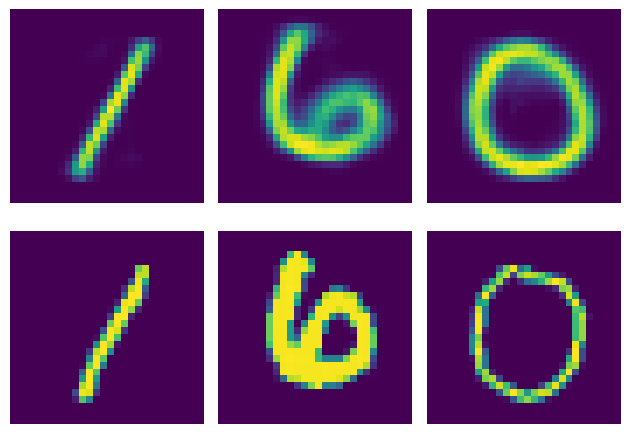

In [190]:
fig, ax = plt.subplots(2, 3)
ax = ax.flatten()
for i, axes in enumerate(ax):
    axes.imshow(tst_pic[i])
    axes.axis('off')
plt.tight_layout()
plt.show()